In [36]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np

from art.attacks import FastGradientMethod
from art.classifiers import KerasClassifier
from art.utils import load_mnist


from keras.datasets import fashion_mnist
from keras.utils import to_categorical

In [37]:

def show_img(img, cmap='gray'):
    plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
    plt.show()


In [38]:

# Step 1: Load the MNIST dataset
db_name = 'fashion'

if db_name=='mnist':
    (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()         
elif db_name=='fashion':
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
# x.shape, y_train.shape
# >>> (?, 28, 28, 1), (?, 10)

In [43]:
print(x_train.shape, y_train.shape)

(60000, 28, 28, 1) (60000, 10)


In [40]:
# Step 2: Create the model

model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])


In [41]:
# Step 3: Create the ART classifier

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)




Epoch 1/3
938/937 [==============================] - 8s 9ms/step - loss: 1.6540 - accuracy: 0.4457
Epoch 2/3
938/937 [==============================] - 12s 13ms/step - loss: 0.7138 - accuracy: 0.7500
Epoch 3/3
938/937 [==============================] - 13s 14ms/step - loss: 0.6173 - accuracy: 0.7803


In [42]:
print(predictions.shape, y_test.shape)

(10000, 10) (10000, 10)


In [44]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

Accuracy on benign test examples: 77.42%


In [45]:

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(classifier=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))


Accuracy on adversarial test examples: 77.45%


387


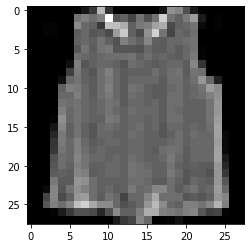

(28, 28, 1)
6
2015


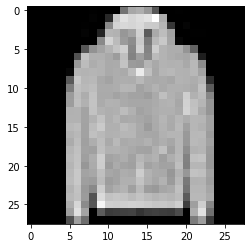

(28, 28, 1)
4
6900


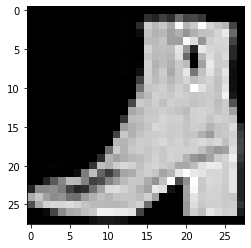

(28, 28, 1)
9
8250


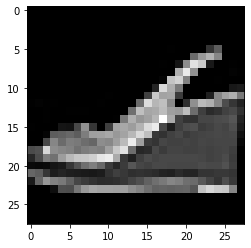

(28, 28, 1)
5
9525


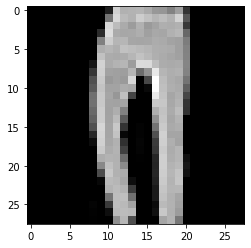

(28, 28, 1)
1


In [46]:
import random
import matplotlib.pyplot as plt


indexes = list(range(len(x_test_adv)))
for i in random.sample(indexes, 5):
    print(i)
    img = x_test_adv[i]
    show_img(img)
    print(img.shape)
    print(np.argmax(predictions[i]))